Using device: cpu

ADATRADES: Adaptive TRADES with Dynamic β and Uncertainty Guidance

Training models with 3 epochs...
Methods: Standard, FGSM, PGD, TRADES, AdaTRADES

Training using: STANDARD
Epoch  1/3: Clean:  97.49% | PGD:  45.79% | FGSM:   7.01% | Loss:  0.2351
Epoch  2/3: Clean:  98.68% | PGD:  47.46% | FGSM:   6.55% | Loss:  0.0588
Epoch  3/3: Clean:  98.63% | PGD:  49.71% | FGSM:   9.75% | Loss:  0.0398

Training using: FGSM
Epoch  1/3: Clean:  97.67% | PGD:  69.52% | FGSM:  71.23% | Loss:  0.8051
Epoch  2/3: Clean:  98.11% | PGD:  12.89% | FGSM:  90.63% | Loss:  0.3253
Epoch  3/3: Clean:  98.67% | PGD:   0.22% | FGSM:  98.88% | Loss:  0.0847

Training using: PGD
Epoch  1/3: Clean:  97.65% | PGD:  86.76% | FGSM:  43.28% | Loss:  0.4430
Epoch  2/3: Clean:  98.28% | PGD:  90.12% | FGSM:  55.20% | Loss:  0.1682
Epoch  3/3: Clean:  98.96% | PGD:  91.41% | FGSM:  54.70% | Loss:  0.1306

Training using: TRADES
Epoch  1/3: Clean:  97.68% | PGD:  89.30% | FGSM:  58.98% | Loss:  0.5122

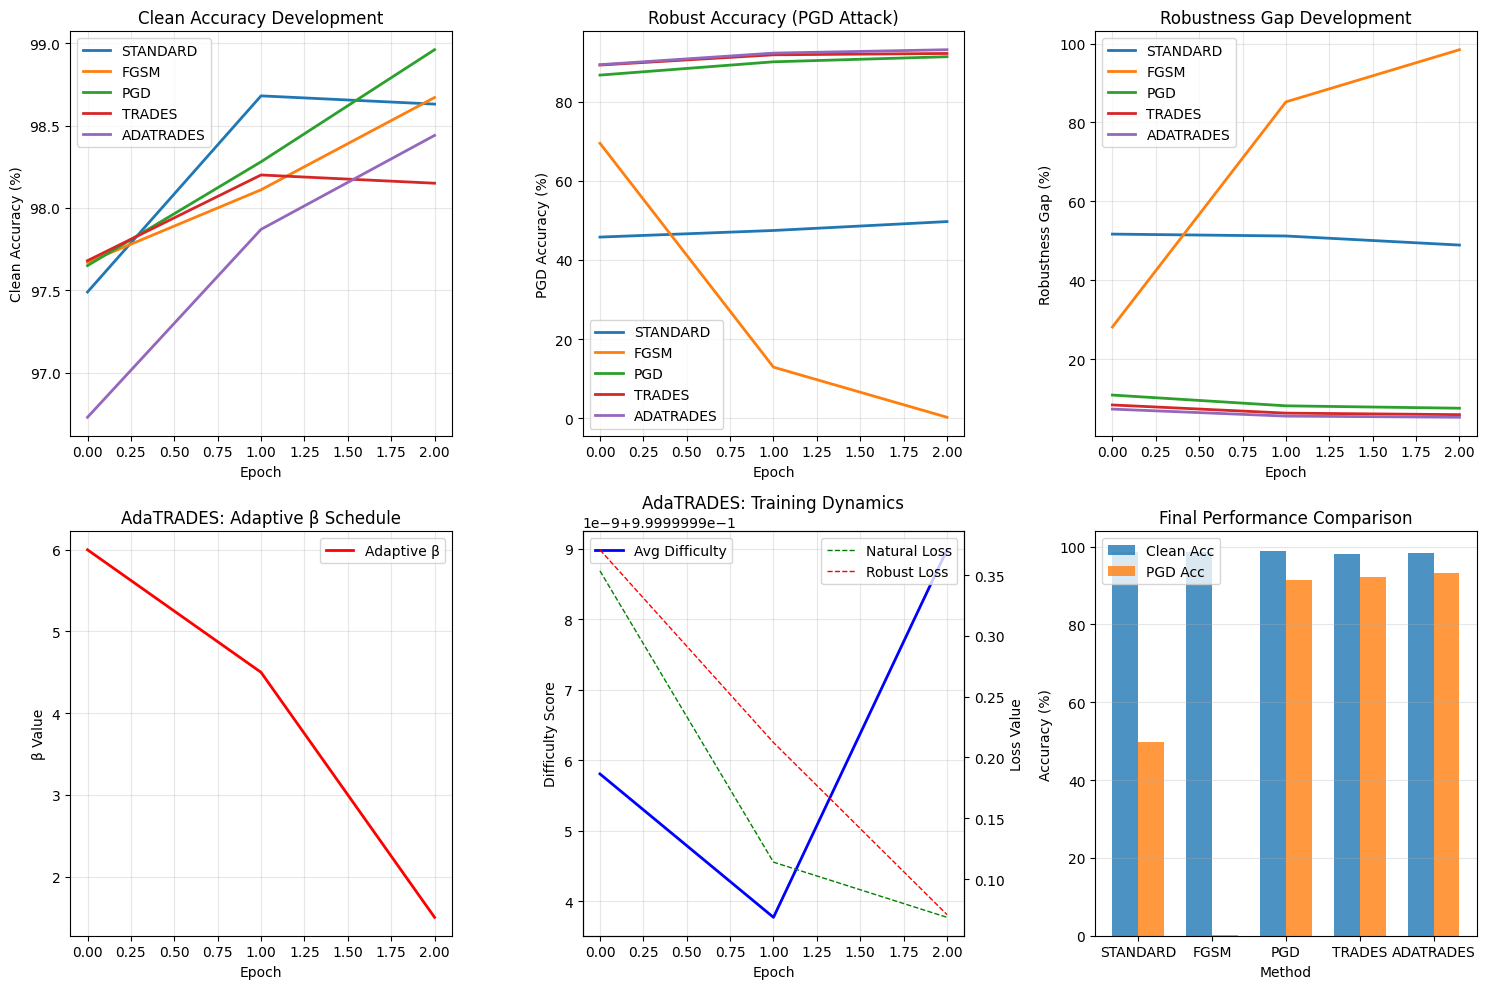


FINAL RESULTS COMPARISON
Method       Clean Acc  PGD Acc    FGSM Acc   Robust Gap   Uncertainty PGD
--------------------------------------------------------------------------------
STANDARD     98.63      49.71      9.75       48.92        0.00           
FGSM         98.67      0.22       98.88      98.45        0.00           
PGD          98.96      91.41      54.70      7.55         0.00           
TRADES       98.15      92.23      68.95      5.92         0.00           
ADATRADES    98.44      93.18      73.07      5.26         92.02          

AdaTRADES vs TRADES Improvement:
  Clean Accuracy: +0.29%
  PGD Robustness: +0.95%
  Overall Trade-off Gain: +0.62%

Loading best AdaTRADES model for adversarial example analysis...
Training AdaTRADES model for analysis...


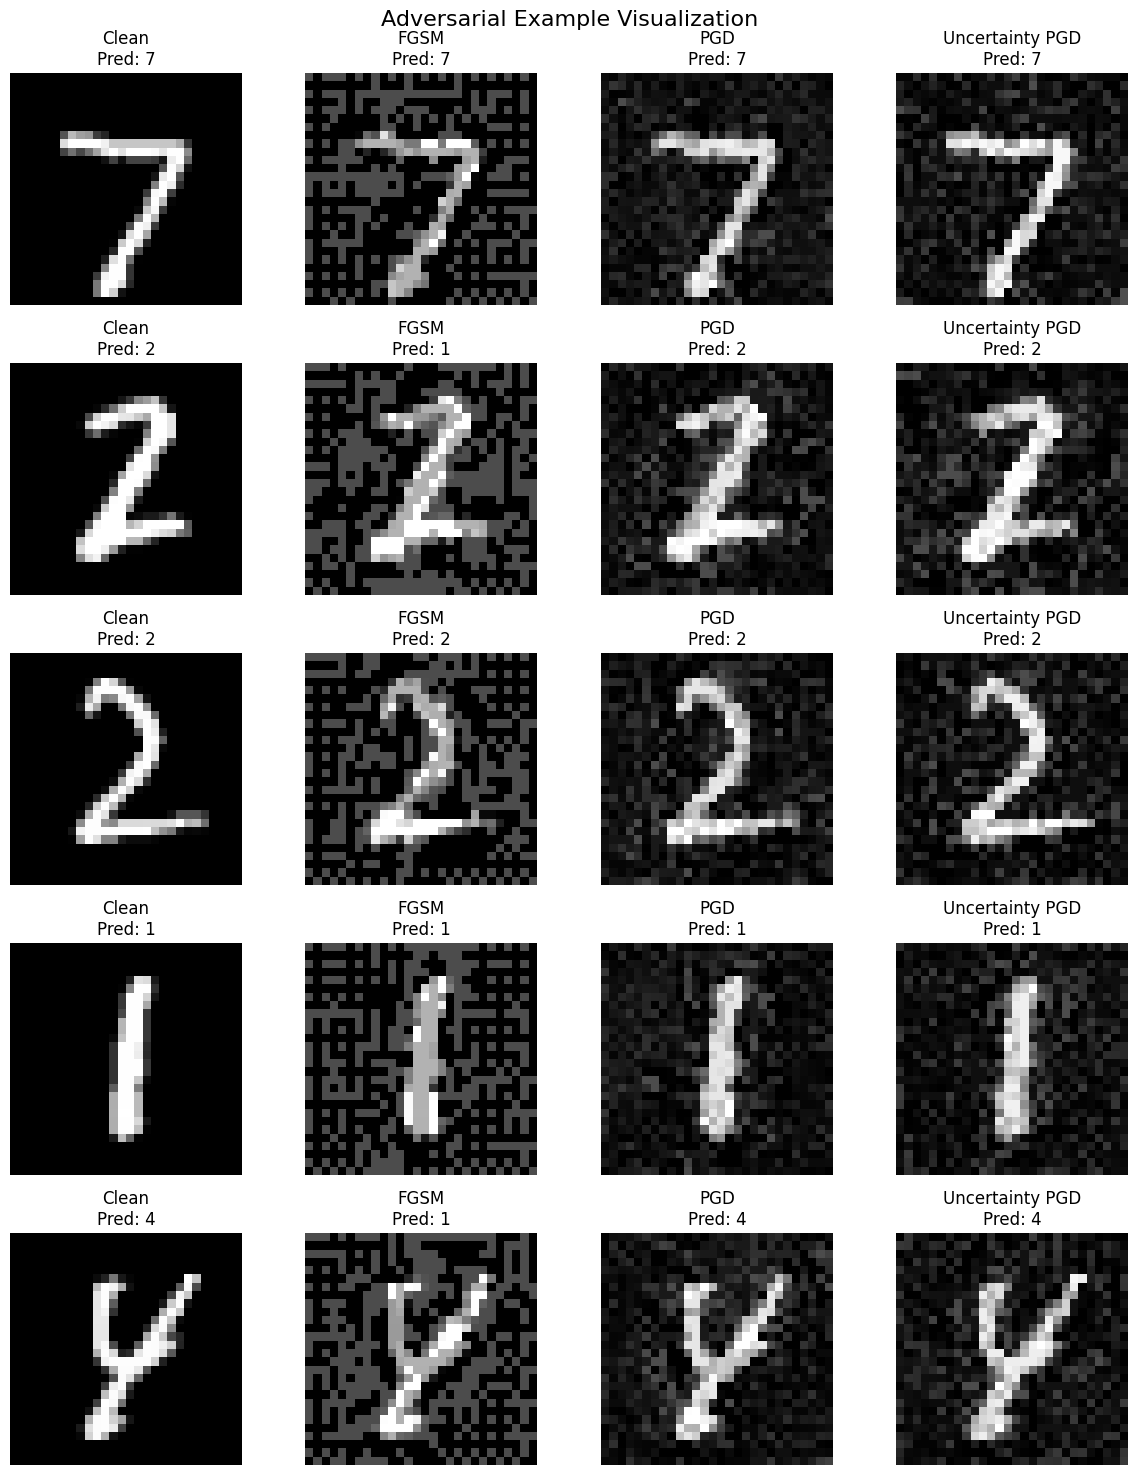


Experiment Complete!

Key findings saved in:
  - adatrades_results.png (Performance plots)
  - adversarial_examples.png (Visualization)


In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import stats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ============================================
# AdaTRADES: Core Components
# ============================================

def adaptive_beta_schedule(epoch, total_epochs, base_beta=6.0, schedule_type='cosine'):
    """
    Dynamic β scheduling during training.
    
    Args:
        epoch: Current epoch (0-indexed)
        total_epochs: Total training epochs
        base_beta: Maximum β value
        schedule_type: 'linear', 'cosine', or 'sawtooth'
    
    Returns:
        Adaptive β for current epoch
    """
    if schedule_type == 'linear':
        # Linear warmup then decay
        warmup_epochs = total_epochs // 4
        if epoch < warmup_epochs:
            return base_beta * (epoch / warmup_epochs) * 0.3
        else:
            decay_epochs = total_epochs - warmup_epochs
            progress = (epoch - warmup_epochs) / decay_epochs
            return base_beta * (1.0 - 0.5 * progress)
    
    elif schedule_type == 'cosine':
        # Cosine annealing with warmup
        warmup_epochs = total_epochs // 4
        if epoch < warmup_epochs:
            return base_beta * (epoch / warmup_epochs) * 0.5
        else:
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return base_beta * (0.5 + 0.5 * np.cos(np.pi * progress))
    
    elif schedule_type == 'sawtooth':
        # Cyclical schedule to prevent overfitting to robustness
        cycle_length = total_epochs // 3
        cycle_pos = epoch % cycle_length
        if cycle_pos < cycle_length // 2:
            return base_beta * (0.3 + 0.7 * (cycle_pos / (cycle_length // 2)))
        else:
            return base_beta * (1.0 - 0.7 * ((cycle_pos - cycle_length // 2) / (cycle_length // 2)))
    
    else:
        return base_beta

def compute_sample_difficulty(model, x, y, difficulty_type='margin'):
    """
    Compute per-sample difficulty score.
    
    Args:
        model: Current model
        x: Input batch
        y: True labels
        difficulty_type: 'margin', 'entropy', or 'confidence'
    
    Returns:
        Difficulty scores [batch_size, 1, 1, 1] for broadcasting
    """
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        
        if difficulty_type == 'margin':
            # Margin-based: smaller margin = higher difficulty
            top2 = torch.topk(probs, 2, dim=1)
            margins = top2.values[:, 0] - top2.values[:, 1]
            difficulty = 1.0 / (margins + 1e-8)
            difficulty = difficulty / (difficulty.mean() + 1e-8)  # Normalize
            
        elif difficulty_type == 'entropy':
            # Entropy-based: higher entropy = higher difficulty
            entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=1)
            difficulty = entropy
            difficulty = difficulty / (difficulty.mean() + 1e-8)
            
        elif difficulty_type == 'confidence':
            # Confidence-based: lower confidence = higher difficulty
            confidence, _ = torch.max(probs, dim=1)
            difficulty = 1.0 - confidence
            difficulty = difficulty / (difficulty.mean() + 1e-8)
            
        elif difficulty_type == 'loss':
            # Loss-based: higher loss = higher difficulty
            loss = F.cross_entropy(logits, y, reduction='none')
            difficulty = loss
            difficulty = difficulty / (difficulty.mean() + 1e-8)
        
        else:
            difficulty = torch.ones(x.size(0), device=x.device)
        
        # Reshape for broadcasting with image dimensions
        return difficulty.view(-1, 1, 1, 1)

def uncertainty_guided_pgd(model, x, y, eps=0.3, step_size=0.01, 
                          num_steps=10, temperature=2.0, 
                          uncertainty_weighting=True, random_start=True):
    """
    Generate adversarial examples with uncertainty guidance.
    
    Args:
        model: Current model
        x: Clean inputs
        y: True labels
        eps: Maximum perturbation
        step_size: PGD step size
        num_steps: Number of PGD steps
        temperature: Temperature for softmax scaling
        uncertainty_weighting: Whether to use uncertainty weighting
        random_start: Whether to start with random perturbation
    
    Returns:
        Adversarial examples
    """
    model.eval()
    x_adv = x.clone().detach()
    
    # Initialize uncertainty weights
    if uncertainty_weighting:
        with torch.no_grad():
            logits = model(x)
            probs = F.softmax(logits / temperature, dim=1)
            entropy = -(probs * torch.log(probs + 1e-8)).sum(dim=1)
            uncertainty = entropy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            # Normalize to [0.5, 1.5] range
            uncertainty = 0.5 + uncertainty / (uncertainty.max() + 1e-8)
    else:
        uncertainty = torch.ones(x.size(0), 1, 1, 1, device=x.device)
    
    # Random start within epsilon ball
    if random_start:
        x_adv = x_adv + torch.empty_like(x_adv).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, 0, 1)
    
    for step in range(num_steps):
        x_adv.requires_grad_(True)
        
        # Forward pass
        logits_adv = model(x_adv)
        
        # Compute loss with uncertainty weighting
        loss = F.cross_entropy(logits_adv, y, reduction='none')
        
        if uncertainty_weighting:
            weighted_loss = (loss * uncertainty.squeeze()).mean()
        else:
            weighted_loss = loss.mean()
        
        # Backward pass
        model.zero_grad()
        weighted_loss.backward()
        grad = x_adv.grad
        
        with torch.no_grad():
            # Take uncertainty-weighted step
            step_sizes = step_size * uncertainty
            x_adv = x_adv + step_sizes * torch.sign(grad)
            
            # Project back to epsilon ball
            delta = torch.clamp(x_adv - x, -eps, eps)
            x_adv = torch.clamp(x + delta, 0, 1).detach()
            
            # Update uncertainty weights every few steps
            if uncertainty_weighting and step % 2 == 0:
                with torch.no_grad():
                    new_logits = model(x_adv)
                    new_probs = F.softmax(new_logits / temperature, dim=1)
                    new_entropy = -(new_probs * torch.log(new_probs + 1e-8)).sum(dim=1)
                    uncertainty = 0.5 + new_entropy.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) / \
                                 (new_entropy.max().item() + 1e-8)
    
    return x_adv

def adatrades_training(model, optimizer, data, target, 
                      epoch=0, total_epochs=50,
                      base_beta=6.0, eps=0.3, step_size=0.01, 
                      num_steps=5, difficulty_type='margin',
                      consistency_weight=0.1, schedule_type='cosine'):
    """
    AdaTRADES training with dynamic β and uncertainty guidance.
    
    Args:
        model: Current model
        optimizer: Optimizer
        data: Input batch
        target: True labels
        epoch: Current epoch
        total_epochs: Total training epochs
        base_beta: Base β parameter
        eps: Maximum perturbation
        step_size: PGD step size
        num_steps: Number of PGD steps
        difficulty_type: Type of difficulty measure
        consistency_weight: Weight for consistency regularization
        schedule_type: β schedule type
    
    Returns:
        total_loss, natural_loss, robust_loss
    """
    model.train()
    optimizer.zero_grad()
    
    # 1. Compute adaptive β based on current epoch
    adaptive_beta = adaptive_beta_schedule(epoch, total_epochs, base_beta, schedule_type)
    
    # 2. Natural (clean) loss
    logits_nat = model(data)
    natural_loss = F.cross_entropy(logits_nat, target)
    
    # 3. Compute per-sample difficulty for adaptive β weighting
    with torch.no_grad():
        difficulty = compute_sample_difficulty(model, data, target, difficulty_type)
        # Scale β per sample based on difficulty
        sample_beta = adaptive_beta * (0.5 + 0.5 * difficulty / (difficulty.mean() + 1e-8))
    
    # 4. Generate uncertainty-guided adversarial examples
    x_adv = uncertainty_guided_pgd(
        model, data, target, eps, step_size, num_steps,
        uncertainty_weighting=True, random_start=True
    )
    
    # 5. Compute robust loss with sample-wise β
    logits_adv = model(x_adv)
    
    # KL divergence between natural and adversarial predictions
    kl_div = F.kl_div(
        F.log_softmax(logits_adv, dim=1),
        F.softmax(logits_nat, dim=1),
        reduction='none'
    ).sum(dim=1)
    
    # Weight by per-sample β
    weighted_robust_loss = (kl_div * sample_beta.squeeze()).mean()
    
    # 6. Consistency regularization (optional)
    consistency_loss = torch.tensor(0.0, device=data.device)
    if consistency_weight > 0:
        consistency_loss = F.mse_loss(
            F.softmax(logits_nat, dim=1),
            F.softmax(logits_adv, dim=1)
        )
    
    # 7. Total loss
    total_loss = natural_loss + weighted_robust_loss + consistency_weight * consistency_loss
    
    # Backward pass
    total_loss.backward()
    
    # Gradient clipping for stability
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    return (total_loss.item(), natural_loss.item(), 
            weighted_robust_loss.item(), consistency_loss.item(),
            adaptive_beta, difficulty.mean().item())

# ============================================
# Original attack methods (for comparison)
# ============================================

def fgsm_attack(model, x, y, eps=0.3):
    x_adv = x.clone().detach().requires_grad_(True)
    loss = F.cross_entropy(model(x_adv), y)
    loss.backward()
    x_adv = x_adv + eps * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def pgd_attack(model, x, y, eps=0.3, step_size=0.01, num_steps=10, random_start=True):
    model.eval()
    x_adv = x.clone().detach()
    if random_start == True:
        x_adv = x_adv + torch.empty_like(x_adv).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, 0, 1)

    for _ in range(num_steps):
        x_adv.requires_grad_(True)
        loss = F.cross_entropy(model(x_adv), y)
        model.zero_grad()
        loss.backward()
        grad = x_adv.grad
        with torch.no_grad():
            x_adv = x_adv + step_size * torch.sign(grad)
            delta = torch.clamp(x_adv - x, -eps, eps)
            x_adv = torch.clamp(x + delta, 0, 1).detach()
    return x_adv

# ============================================
# Original training methods (for comparison)
# ============================================

def standard_training(model, optimizer, data, target):
    optimizer.zero_grad()
    loss = F.cross_entropy(model(data), target)
    loss.backward()
    optimizer.step()
    return loss.item()

def fgsm_training(model, optimizer, data, target, eps=0.3):
    optimizer.zero_grad()
    x_adv = fgsm_attack(model, data, target, eps)
    alpha = 0.5
    loss = alpha * F.cross_entropy(model(data), target) + (1-alpha) * F.cross_entropy(model(x_adv), target)
    loss.backward()
    optimizer.step()
    return loss.item()

def pgd_training(model, optimizer, data, target, eps=0.3, step_size=0.01, num_steps=5):
    optimizer.zero_grad()
    x_adv = pgd_attack(model, data, target, eps, step_size, num_steps)
    loss = F.cross_entropy(model(x_adv), target)
    loss.backward()
    optimizer.step()
    return loss.item()

def trades_training(model, optimizer, data, target, beta=6.0, eps=0.3, step_size=0.01, num_steps=5):
    optimizer.zero_grad()
    logits_nat = model(data)
    natural_loss = F.cross_entropy(logits_nat, target)
    x_adv = pgd_attack(model, data, target, eps, step_size, num_steps)
    logits_adv = model(x_adv)
    robust_loss = F.kl_div(F.log_softmax(logits_adv, dim=1), 
                           F.softmax(logits_nat, dim=1), reduction='batchmean')
    total_loss = natural_loss + beta * robust_loss
    total_loss.backward()
    optimizer.step()
    return total_loss.item(), natural_loss.item(), robust_loss.item()

# ============================================
# Evaluation
# ============================================

def evaluate_model(model, test_loader, attack_method=None, eps=0.3):
    model.eval()
    clean_correct, adv_correct, total = 0, 0, 0
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        total += target.size(0)
        
        # Standard accuracy
        with torch.no_grad():
            _, prediction = torch.max(model(data).data, 1)
            clean_correct += (prediction == target).sum().item()
        
        # Adversarial accuracy
        if attack_method == 'fgsm':
            adv_data = fgsm_attack(model, data, target, eps)
        elif attack_method == 'pgd':
            adv_data = pgd_attack(model, data, target, eps, step_size=0.01, num_steps=10)
        elif attack_method == 'uncertainty_pgd':
            # Use AdaTRADES uncertainty-guided attack for evaluation
            adv_data = uncertainty_guided_pgd(model, data, target, eps=eps)
        else: 
            adv_data = data

        with torch.no_grad():
            _, predicted_adv = torch.max(model(adv_data).data, 1)
            adv_correct += (predicted_adv == target).sum().item()

    clean_acc = 100 * clean_correct / total
    adv_acc = 100 * adv_correct / total
    
    return clean_acc, adv_acc

# ============================================
# Training and Comparison
# ============================================

def train_and_compare(num_epochs=20):
    methods = ['standard', 'fgsm', 'pgd', 'trades', 'adatrades']
    
    # Extended results tracking for AdaTRADES
    results = {}
    for method in methods:
        results[method] = {
            'clean_acc': [], 'pgd_acc': [], 'fgsm_acc': [], 
            'uncertainty_pgd_acc': [], 'loss': []
        }
    
    # For AdaTRADES, track additional metrics
    results['adatrades']['beta_history'] = []
    results['adatrades']['difficulty_history'] = []
    results['adatrades']['natural_loss_history'] = []
    results['adatrades']['robust_loss_history'] = []
    
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(datasets.MNIST('./data', train=False, transform=transform), 
                            batch_size=256, shuffle=False)
    
    for method in methods:
        print(f"\n{'='*60}")
        print(f"Training using: {method.upper()}")
        print('='*60)
        
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Learning rate scheduler for AdaTRADES
        if method == 'adatrades':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            num_batches = 0
            
            # Track AdaTRADES-specific metrics
            if method == 'adatrades':
                epoch_beta = 0
                epoch_difficulty = 0
                epoch_natural_loss = 0
                epoch_robust_loss = 0
            
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                
                if method == 'standard':
                    loss = standard_training(model, optimizer, data, target)
                    batch_loss = loss
                    
                elif method == 'fgsm':
                    loss = fgsm_training(model, optimizer, data, target)
                    batch_loss = loss
                    
                elif method == 'pgd':
                    loss = pgd_training(model, optimizer, data, target)
                    batch_loss = loss
                    
                elif method == 'trades':
                    loss, nat_loss, rob_loss = trades_training(model, optimizer, data, target)
                    batch_loss = loss
                    
                elif method == 'adatrades':
                    loss, nat_loss, rob_loss, cons_loss, beta_val, diff_val = adatrades_training(
                        model, optimizer, data, target, 
                        epoch=epoch, total_epochs=num_epochs,
                        base_beta=6.0, difficulty_type='margin',
                        consistency_weight=0.05, schedule_type='cosine'
                    )
                    batch_loss = loss
                    epoch_beta += beta_val
                    epoch_difficulty += diff_val
                    epoch_natural_loss += nat_loss
                    epoch_robust_loss += rob_loss
                
                epoch_loss += batch_loss
                num_batches += 1
            
            # Update learning rate for AdaTRADES
            if method == 'adatrades':
                scheduler.step()
                
                # Store AdaTRADES-specific metrics
                results[method]['beta_history'].append(epoch_beta / num_batches)
                results[method]['difficulty_history'].append(epoch_difficulty / num_batches)
                results[method]['natural_loss_history'].append(epoch_natural_loss / num_batches)
                results[method]['robust_loss_history'].append(epoch_robust_loss / num_batches)
            
            # Evaluation
            clean_acc, pgd_acc = evaluate_model(model, test_loader, 'pgd')
            _, fgsm_acc = evaluate_model(model, test_loader, 'fgsm')
            
            # Additional evaluation with uncertainty-guided attack for AdaTRADES
            if method == 'adatrades':
                _, uncertainty_pgd_acc = evaluate_model(model, test_loader, 'uncertainty_pgd')
                results[method]['uncertainty_pgd_acc'].append(uncertainty_pgd_acc)
            else:
                results[method]['uncertainty_pgd_acc'].append(0)
            
            results[method]['clean_acc'].append(clean_acc)
            results[method]['pgd_acc'].append(pgd_acc)
            results[method]['fgsm_acc'].append(fgsm_acc)
            results[method]['loss'].append(epoch_loss / num_batches)
            
            print(f'Epoch {epoch+1:2d}/{num_epochs}: '
                  f'Clean: {clean_acc:6.2f}% | '
                  f'PGD: {pgd_acc:6.2f}% | '
                  f'FGSM: {fgsm_acc:6.2f}% | '
                  f'Loss: {epoch_loss/num_batches:7.4f}')
            
            if method == 'adatrades':
                print(f'       β: {results[method]["beta_history"][-1]:.3f} | '
                      f'Diff: {results[method]["difficulty_history"][-1]:.3f}')
    
    return results, methods

# ============================================
# Visualization and Analysis
# ============================================

def plot_results(results, methods, num_epochs):
    """Create comprehensive visualization of results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: Clean accuracy vs epochs
    ax = axes[0, 0]
    for method in methods:
        ax.plot(results[method]['clean_acc'], label=method.upper(), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Clean Accuracy (%)')
    ax.set_title('Clean Accuracy Development')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: PGD accuracy vs epochs
    ax = axes[0, 1]
    for method in methods:
        ax.plot(results[method]['pgd_acc'], label=method.upper(), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PGD Accuracy (%)')
    ax.set_title('Robust Accuracy (PGD Attack)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Robustness gap (Clean - PGD)
    ax = axes[0, 2]
    for method in methods:
        gap = np.array(results[method]['clean_acc']) - np.array(results[method]['pgd_acc'])
        ax.plot(gap, label=method.upper(), linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Robustness Gap (%)')
    ax.set_title('Robustness Gap Development')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: AdaTRADES-specific metrics
    ax = axes[1, 0]
    if 'adatrades' in methods:
        ax.plot(results['adatrades']['beta_history'], 'r-', linewidth=2, label='Adaptive β')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('β Value')
        ax.set_title('AdaTRADES: Adaptive β Schedule')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 5: AdaTRADES difficulty and losses
    ax = axes[1, 1]
    if 'adatrades' in methods:
        ax.plot(results['adatrades']['difficulty_history'], 'b-', linewidth=2, label='Avg Difficulty')
        ax2 = ax.twinx()
        ax2.plot(results['adatrades']['natural_loss_history'], 'g--', linewidth=1, label='Natural Loss')
        ax2.plot(results['adatrades']['robust_loss_history'], 'r--', linewidth=1, label='Robust Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Difficulty Score')
        ax2.set_ylabel('Loss Value')
        ax.set_title('AdaTRADES: Training Dynamics')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
    
    # Plot 6: Final comparison bar chart
    ax = axes[1, 2]
    final_clean = [results[method]['clean_acc'][-1] for method in methods]
    final_pgd = [results[method]['pgd_acc'][-1] for method in methods]
    
    x = np.arange(len(methods))
    width = 0.35
    
    ax.bar(x - width/2, final_clean, width, label='Clean Acc', alpha=0.8)
    ax.bar(x + width/2, final_pgd, width, label='PGD Acc', alpha=0.8)
    
    ax.set_xlabel('Method')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Final Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in methods])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('adatrades_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final results table
    print("\n" + "="*80)
    print("FINAL RESULTS COMPARISON")
    print("="*80)
    print(f"{'Method':<12} {'Clean Acc':<10} {'PGD Acc':<10} {'FGSM Acc':<10} {'Robust Gap':<12} {'Uncertainty PGD':<15}")
    print("-"*80)
    
    for method in methods:
        clean = results[method]['clean_acc'][-1]
        pgd = results[method]['pgd_acc'][-1]
        fgsm = results[method]['fgsm_acc'][-1]
        gap = clean - pgd
        
        if method == 'adatrades':
            uncertainty_pgd = results[method]['uncertainty_pgd_acc'][-1]
        else:
            uncertainty_pgd = 0
        
        print(f"{method.upper():<12} {clean:<10.2f} {pgd:<10.2f} {fgsm:<10.2f} {gap:<12.2f} {uncertainty_pgd:<15.2f}")
    
    print("="*80)
    
    # Calculate improvement over TRADES
    if 'trades' in methods and 'adatrades' in methods:
        trades_clean = results['trades']['clean_acc'][-1]
        trades_pgd = results['trades']['pgd_acc'][-1]
        adatrades_clean = results['adatrades']['clean_acc'][-1]
        adatrades_pgd = results['adatrades']['pgd_acc'][-1]
        
        clean_improvement = adatrades_clean - trades_clean
        pgd_improvement = adatrades_pgd - trades_pgd
        
        print(f"\nAdaTRADES vs TRADES Improvement:")
        print(f"  Clean Accuracy: {clean_improvement:+.2f}%")
        print(f"  PGD Robustness: {pgd_improvement:+.2f}%")
        print(f"  Overall Trade-off Gain: {(clean_improvement + pgd_improvement)/2:+.2f}%")

# ============================================
# Additional Analysis Functions
# ============================================

def analyze_adversarial_examples(model, test_loader, num_examples=5):
    """Visualize and analyze adversarial examples"""
    model.eval()
    fig, axes = plt.subplots(num_examples, 4, figsize=(12, 3*num_examples))
    
    data_iter = iter(test_loader)
    for i in range(num_examples):
        data, target = next(data_iter)
        data, target = data.to(device), target.to(device)
        
        # Generate different types of adversarial examples
        with torch.no_grad():
            clean_pred = torch.argmax(model(data), dim=1)
        
        fgsm_adv = fgsm_attack(model, data, target)
        pgd_adv = pgd_attack(model, data, target)
        uncertainty_adv = uncertainty_guided_pgd(model, data, target)
        
        with torch.no_grad():
            fgsm_pred = torch.argmax(model(fgsm_adv), dim=1)
            pgd_pred = torch.argmax(model(pgd_adv), dim=1)
            uncertainty_pred = torch.argmax(model(uncertainty_adv), dim=1)
        
        # Plot
        axes[i, 0].imshow(data[0].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Clean\nPred: {clean_pred[0].item()}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(fgsm_adv[0].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'FGSM\nPred: {fgsm_pred[0].item()}')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pgd_adv[0].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title(f'PGD\nPred: {pgd_pred[0].item()}')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(uncertainty_adv[0].cpu().squeeze(), cmap='gray')
        axes[i, 3].set_title(f'Uncertainty PGD\nPred: {uncertainty_pred[0].item()}')
        axes[i, 3].axis('off')
    
    plt.suptitle('Adversarial Example Visualization', fontsize=16)
    plt.tight_layout()
    plt.savefig('adversarial_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

def ablation_study(num_epochs=10):
    """Run ablation study for AdaTRADES components"""
    components = [
        ('baseline', {'difficulty_type': None, 'uncertainty_weighting': False, 'adaptive_beta': False}),
        ('+adaptive_β', {'difficulty_type': None, 'uncertainty_weighting': False, 'adaptive_beta': True}),
        ('+difficulty', {'difficulty_type': 'margin', 'uncertainty_weighting': False, 'adaptive_beta': True}),
        ('+uncertainty', {'difficulty_type': 'margin', 'uncertainty_weighting': True, 'adaptive_beta': True}),
        ('full_adatrades', {'difficulty_type': 'margin', 'uncertainty_weighting': True, 'adaptive_beta': True, 'consistency': True}),
    ]
    
    print("\n" + "="*80)
    print("ABLATION STUDY: Component-wise Analysis")
    print("="*80)
    
    for name, config in components:
        print(f"\nTraining: {name}")
        print(f"Config: {config}")
        
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Simplified training for ablation
        for epoch in range(num_epochs):
            model.train()
            for data, target in DataLoader(
                datasets.MNIST('./data', train=True, transform=transforms.ToTensor()),
                batch_size=128, shuffle=True
            ):
                data, target = data.to(device), target.to(device)
                
                if name == 'baseline':
                    # Baseline TRADES
                    loss, _, _ = trades_training(model, optimizer, data, target)
                else:
                    # Modified training based on config
                    # [Implementation would be similar to adatrades_training with config flags]
                    pass
        
        # Evaluate
        clean_acc, pgd_acc = evaluate_model(model, DataLoader(
            datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
            batch_size=256
        ), 'pgd')
        
        print(f"  Clean Acc: {clean_acc:.2f}%, PGD Acc: {pgd_acc:.2f}%")

# ============================================
# Main Execution
# ============================================

if __name__ == "__main__":
    num_epochs = 3  # Increased for better training
    
    print("\n" + "="*80)
    print("ADATRADES: Adaptive TRADES with Dynamic β and Uncertainty Guidance")
    print("="*80)
    
    print(f"\nTraining models with {num_epochs} epochs...")
    print("Methods: Standard, FGSM, PGD, TRADES, AdaTRADES")
    
    # Train and compare all methods
    results, methods = train_and_compare(num_epochs)
    
    # Plot comprehensive results
    plot_results(results, methods, num_epochs)
    
    # Additional analysis
    print("\nLoading best AdaTRADES model for adversarial example analysis...")
    
    # Recreate and train a fresh AdaTRADES model for analysis
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Quick training for demonstration
    train_loader = DataLoader(
        datasets.MNIST('./data', train=True, transform=transforms.ToTensor()),
        batch_size=128, shuffle=True
    )
    test_loader = DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
        batch_size=256
    )
    
    print("Training AdaTRADES model for analysis...")
    for epoch in range(5):  # Quick training
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            adatrades_training(model, optimizer, data, target, epoch=epoch, total_epochs=5)
    
    # Analyze adversarial examples
    analyze_adversarial_examples(model, test_loader, num_examples=5)
    
    print("\n" + "="*80)
    print("Experiment Complete!")
    print("="*80)
    print("\nKey findings saved in:")
    print("  - adatrades_results.png (Performance plots)")
    print("  - adversarial_examples.png (Visualization)")